This notebook attempts to select an evaluation metric for audio quality. 

# Evaluation Metrics: Option 1

If a .wav file is the gold standard, we will want to try to make other types of audio similar to .wav files. 

### The plan:
1. Extract the points from a .wav file
2. Create a line that connects all the points (and recreates the original audio wave)
3. Compress the .wav file into a lossy format such as .mp3, add noise
4. Convert this lossy file back into .wav so it has the same bit depth, etc. as the original, but is still low-quality.
6. Use method from 2 to get the audio wave from this compressed .wav format. This is our starting point. 
7. Run the mp3.wav file through our model to restore it (I will call this restored .mp3).
8. Use method from 2 to get the audio wave from the restored .mp3
9. Compare the restored .mp3 to the original .wav file


**Important note:** This will mean that the output file from the model must be exactly the same length as the input file. 

### An example file

In [13]:
import array
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
from pydub.utils import get_array_type
import wave # https://docs.python.org/3/library/wave.html

In [1]:
import os
os.getcwd()

'/Users/patriciadegner/Documents/MIDS/Capstone/Audio-Upscaling/EDA'

In [5]:
DATA_DIR = "../../data/welsh_english_male/wem_02484_00002251569.wav"
wav_file = wave.open(DATA_DIR)
wav_file.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=323584, comptype='NONE', compname='not compressed')

In [31]:
sound = AudioSegment.from_file(file=DATA_DIR)
sound

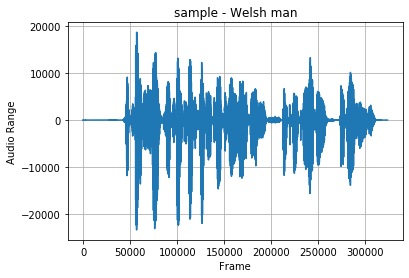

In [15]:
left = sound.split_to_mono()[0]

bit_depth = left.sample_width * 8
array_type = get_array_type(bit_depth)

numeric_array = array.array(array_type, left._data)

t = np.arange(0, len(numeric_array))
fig, ax = plt.subplots()
ax.plot(t, numeric_array)
ax.set(xlabel='Frame', ylabel='Audio Range',
       title='sample - Welsh man')
ax.grid()
plt.show()

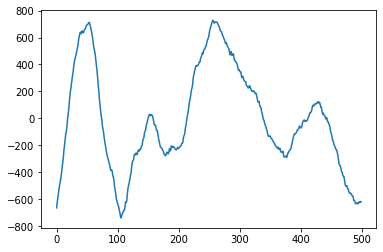

In [30]:
plt.plot(numeric_array[50000:50500])

In [126]:
print(len(numeric_array), len(set(numeric_array)), max(numeric_array))

323584 19411 18693


In [52]:
type(numeric_array)

array.array

In [127]:
def audio_similarity(audio1, audio2):
    '''
    Input directory to file names.
    
    Output the similarity between two audio files.
    '''
    
    # Get info for audio1
    left = AudioSegment.from_file(file=audio1).split_to_mono()[0]
    bit_depth = left.sample_width * 8
    array_type = get_array_type(bit_depth)
    numeric_array1 = array.array(array_type, left._data)
    
    # Get info for audio2
    left = AudioSegment.from_file(file=audio2).split_to_mono()[0]
    bit_depth = left.sample_width * 8
    array_type = get_array_type(bit_depth)
    numeric_array2 = array.array(array_type, left._data)
    
    assert len(numeric_array1) == len(numeric_array2), "Audio files must be the same length."
    
    sum_diff_sq = 0
    for i in numeric_array1:
        sum_diff_sq += (numeric_array1[i] - numeric_array2[i])**2
    avg_diff = (sum_diff_sq / len(numeric_array1))**(1/2)
    diff_ratio = avg_diff / len(numeric_array1)
    
    return avg_diff, diff_ratio

In [114]:
### Create audio file to test the function
import random
test_audio = AudioSegment.from_file(file = DATA_DIR)
audio_data = test_audio.split_to_mono()[0]._data

# add noise to audio data to create mod_audio
mod_audio = []
for i in test_audio.split_to_mono()[0]._data:
    add_noise = random.randint(-3,3)
    if i + add_noise <0:
        i = 0
    elif i + add_noise >255:
        i = 255
    else:
        i = i + add_noise
    mod_audio.append(i)
mod_audio = bytes(mod_audio)

# write mod_aduio to .wav file
sampleRate = 48000 # hertz
frequency = 440.0 # hertz
obj = wave.open('wav_test.wav','w')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(48000)
obj.setnframes(323584)
obj.writeframesraw(mod_audio)
obj.close()

In [121]:
# Listen to both audio files
audio_full = AudioSegment.from_file(file=DATA_DIR)
audio_full

In [122]:
audio_altered = AudioSegment.from_file(file="wav_test.wav")
audio_altered

In [128]:
# Test the function on original and modified .wav files
print(audio_similarity(DATA_DIR, "wav_test.wav"))

# Show that it works when the files are exactly the same
audio_similarity(DATA_DIR, DATA_DIR)

(368.08619105928364, 0.0011375290220137079)


(0.0, 0.0)

# Evaluation Metrics: Option 2

https://medium.com/better-programming/assessing-audio-quality-with-deep-learning-f66d1761f938

Predict the mean opinion score. 

This would be a good way to go if our only goal is clearer quality for Zoom, Skype, etc.

Potential issue: the dataset is 384 audio files of four speakers (two male and two female) with 24 opinions about each file.